<a href="https://colab.research.google.com/github/Aashi779/DeepLearningwithPytorch/blob/main/ImageProcessingPytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- torch vision - dataset, model architectures, image transformations
- torchvision.dataset
- torchvision.models
- torchvision.transformers
- torchvision.utils.data.DataLoaders

In [1]:
# base package
import torch
# neural network package
from torch import nn
# torchvision for image processing
import torchvision
# to load dataset from torchvision
from torchvision import datasets
# to perfrom transform and augmentation
from torchvision.transforms import ToTensor
import torch.nn.functional as F
# to plot images data
import matplotlib
import matplotlib.pyplot as plt

In [2]:
train_data = datasets.FashionMNIST(
    root = "dataset", # location where data will be downloaded
    train = True, # to download training data
    download = True, # download data if it doesn't exist
    transform = ToTensor(), # convert images into Torch tensor
    target_transform = None
    )
test_data = datasets.FashionMNIST(
    root = "dataset", # location where data will be downloaded
    train = False, # to download training data
    download = True, # download data if it doesn't exist
    transform = ToTensor(), # convert images into Torch tensor
    )

100%|██████████| 26421880/26421880 [00:03<00:00, 8393245.88it/s] 


Extracting dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 144323.45it/s]


Extracting dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2567600.17it/s]


Extracting dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 3761720.73it/s]

Extracting dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



In [3]:
type(train_data)

torchvision.datasets.mnist.FashionMNIST

In [4]:
# will show number of images and dimension of images
train_data.data.shape

torch.Size([60000, 28, 28])

In [5]:
img, label = train_data[100]

In [6]:
label

8

In [7]:
img.shape # [color_channel, height, width]

torch.Size([1, 28, 28])

In [8]:
len(train_data.data)

60000

In [9]:
len(test_data.data)

10000

In [10]:
# names of classes
train_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

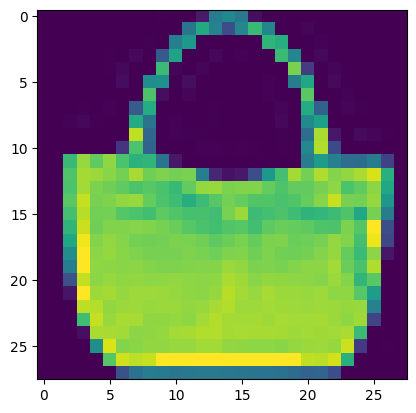

In [11]:
plt.imshow(img.squeeze())
plt.show()

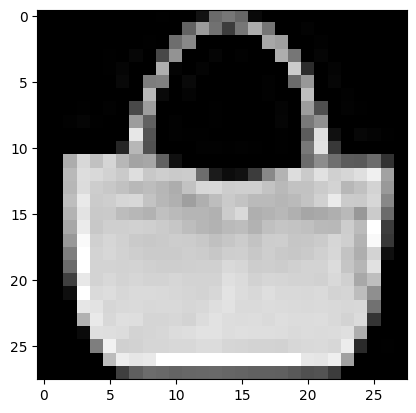

In [12]:
plt.imshow(img.squeeze(), cmap = "gray")
plt.show()

In [13]:
img.shape

torch.Size([1, 28, 28])

In [14]:
img.squeeze().shape

torch.Size([28, 28])

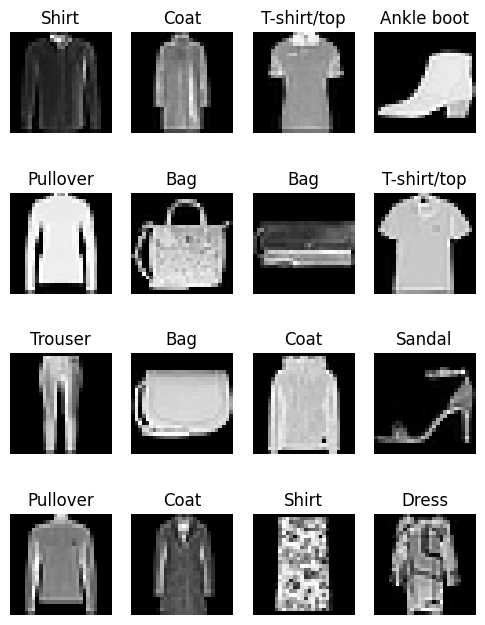

In [15]:
class_names = train_data.classes

fig = plt.figure(figsize = (6, 8))
rows = 4
cols = 4
for i in range(1, rows*cols + 1):
  # get a random number between 0 to 60000
  random_index = torch.randint(0, len(train_data), size = [1]).item()
  # get image and target of that random index
  img, target = train_data[random_index]
  # add subplot for each image
  fig.add_subplot(rows, cols, i)
  # plot image using matplotlib, cmap - set color map as grayscale
  plt.imshow(img.squeeze(), cmap = "gray")
  # add title on each subplot
  plt.title(class_names[target])
  # exclude x and y axis labels
  plt.axis(False)

Helpful for data visualization in research paper

In [17]:
# Data loaders - used to load data, turns large datasets into smaller chunks
# known as batches or mini-batch, generally we put chunk size of 32



In [16]:
# number of batches, each batch having 32 images
60000/32

1875.0

In [17]:
from torch.utils.data import DataLoader

In [18]:
BATCH_SIZE = 32
train_data_loader = DataLoader(train_data, # dataset to be converted into batches
                               batch_size = BATCH_SIZE,
                               shuffle = True) # shuffle the images for each epoch
test_data_loader = DataLoader(test_data,
                               batch_size = BATCH_SIZE, # how many samples per batch
                               shuffle = False)

In [21]:
# Build Base model - for classifying - ANN
class Model(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(), # [1, 28, 28] to [1, 28*28] -> 3d to 2d
        nn.Linear(in_features = input_shape, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = output_shape),
        nn.ReLU()
    )
  def forward(self, x):
    return self.layer_stack(x)

# Why have we flatten the images - Multi-Dimensional arrays take more amount of
# memory while 1-D arrays take less memory, which is the most important reason why
#  we flatten the Image Array before processing/feeding the information to our
#  model. In most cases, we will be dealing with a dataset which contains a large
#  amount of images thus flattening helps in decreasing the memory as well as
#  reducing the time to train the model.

In [19]:
# CNN model
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    # in_channels - 3 - number of channels in input image - if color then 3 otherwise 1
    # out_channels - 6 - number of channels/filters produced by convolution
    # kernel_size - (3,3) / 3
    self.conv1 = nn.Conv2d(1,6,5)
    # Poolin Layer - MaxPool2d(pool_size, stride)
    self.pool = nn.MaxPool2d(2,2)
    # Convolutional Layer
    self.conv2 = nn.Conv2d(6,16,5)
    # Fully Connected Layer - ANN
    # Hidden Layer
    self.fc_1 = nn.Linear(16*4*4, 64)
    # Hidden Layer
    self.fc_2 = nn.Linear(64,32)
    # Output Layer, 10 - 10 classes
    self.fc_3 = nn.Linear(32,10)

  def forward(self, x):
    # apply convolutional + activation + max pooling
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    # x = torch.flatten(x,1)
    x = x.reshape(-1, 16*4*4)
    x = F.tanh(self.fc_1(x))
    x = F.tanh(self.fc_2(x))
    x = self.fc_3(x)
    return x


In [20]:
model = Model()

In [24]:
# create an object of the class
# input_shape = 784 that is 28*28 -> number of input features
# hidden units = neurons in hidden layer
# output_shape = 10 since we have 10 categories

model = Model(input_shape = 784, hidden_units = 64, output_shape = len(class_names))


TypeError: ignored

In [21]:
model.to("cuda")

Model(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc_1): Linear(in_features=256, out_features=64, bias=True)
  (fc_2): Linear(in_features=64, out_features=32, bias=True)
  (fc_3): Linear(in_features=32, out_features=10, bias=True)
)

Here we are dealing with multiclassification problems


In [22]:
# Evaluation metric
def accuracy(y_true, y_pred):
  correct_classification = torch.eq(y_true, y_pred).sum().item()
  acc = (correct_classification/len(y_pred))*100
  return acc


In [23]:
# Loss function, since it is a multiclassification problem that is why we are using cross entropy
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.01)

The torch. device enables you to specify the device type responsible to load a tensor into memory. The function expects a string argument specifying the device type. You can even pass an ordinal like the device index. or leave it unspecified for PyTorch to use the currently available device.

In [24]:
def train_step(model, data_loader, loss_fn, optimizer, accuracy, device):
  train_loss, train_acc = 0, 0
  model.to(device)

  for batch, (X,y) in enumerate(data_loader):
    X,y = X.to(device), y.to(device)

    # Feedforward
    y_pred = model(X)

    # Calculate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += accuracy(y, y_pred.argmax(dim=1))
    # Backpropagate
    optimizer.zero_grad()
    # Loss Backward
    loss.backward()
    # optimizer step
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train Acc : {train_acc:.3f} | Train Loss : {train_loss:.3f}\n")

def test_step(model, data_loader, loss_fn, accuracy, device):
  test_loss, test_acc = 0, 0
  model.to(device)
  model.eval()

  with torch.inference_mode():
    for X,y in data_loader:
      X,y = X.to(device), y.to(device)

      # Feedforward
      y_pred = model(X)

      # Calculate loss
      loss = loss_fn(y_pred, y)
      test_loss += loss
      test_acc += accuracy(y, y_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"\nTest Acc : {test_acc:.3f} | Test Loss : {test_loss:.3f}\n")

# argmax - gives the index of max probability element

In [25]:
# tqdm = used to show progress of loop
from tqdm import tqdm

epochs = 8
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n")
  train_step(model, train_data_loader, loss_function, optimizer, accuracy, "cuda")
  test_step(model, test_data_loader, loss_function, accuracy, "cuda")

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 0

Train Acc : 78.167 | Train Loss : 0.591



 12%|█▎        | 1/8 [00:14<01:44, 14.93s/it]


Test Acc : 75.699 | Test Loss : 0.632

Epoch: 1

Train Acc : 79.738 | Train Loss : 0.549



 25%|██▌       | 2/8 [00:28<01:26, 14.39s/it]


Test Acc : 79.613 | Test Loss : 0.535

Epoch: 2

Train Acc : 80.052 | Train Loss : 0.540



 38%|███▊      | 3/8 [00:42<01:10, 14.10s/it]


Test Acc : 77.157 | Test Loss : 0.607

Epoch: 3

Train Acc : 80.035 | Train Loss : 0.541



 50%|█████     | 4/8 [00:56<00:55, 13.87s/it]


Test Acc : 77.756 | Test Loss : 0.594

Epoch: 4

Train Acc : 78.368 | Train Loss : 0.568



 62%|██████▎   | 5/8 [01:09<00:41, 13.76s/it]


Test Acc : 78.544 | Test Loss : 0.588

Epoch: 5

Train Acc : 78.065 | Train Loss : 0.577



 75%|███████▌  | 6/8 [01:24<00:28, 14.00s/it]


Test Acc : 75.679 | Test Loss : 0.652

Epoch: 6

Train Acc : 77.970 | Train Loss : 0.582



 88%|████████▊ | 7/8 [01:37<00:13, 13.86s/it]


Test Acc : 75.160 | Test Loss : 0.622

Epoch: 7

Train Acc : 78.193 | Train Loss : 0.582



100%|██████████| 8/8 [01:51<00:00, 13.95s/it]


Test Acc : 77.216 | Test Loss : 0.599

